In [1]:
using Flux
using JLD2
using SparseArrays
using LightGraphs
using LightGraphs: SimpleGraphs
using LinearAlgebra
using Flux: glorot_uniform, onecold, @epochs, throttle, train!, batch
using Statistics: mean
using Random: randperm
using Base.Iterators: partition

In [2]:
# Data loading and prep
@load "data/cora_features.jld2" features
@load "data/cora_labels.jld2" labels
@load "data/cora_graph.jld2" g

num_nodes = 2708
num_features = 1433
target_category = 7

# convert values to Float32 for training
features = map(Float32, features)

# convert to dense
feature_matrix = Matrix(features)
label_matrix = Matrix(labels);

In [3]:
# split a feature array and label array into train and test. Shuffled as well.
function train_test_split(features::Array{Float32,2}, labels::Array{Int64,2}; split::Float32=.2f0, num::Int64=num_nodes)
    feature_vecs = [features[:,node] for node in 1:num] # all feature vectors
    label_vecs = [labels[:,node] for node in 1:num] # all label vectors

    rand_indices = randperm(num) # get a list of random indices
    split_index = Int(floor(num*(1-split)))
    train_indices = rand_indices[1:split_index] # indices of the training data
    test_indices = rand_indices[split_index+1:num] # indices of the testing data

    X_train = [feature_vecs[i] for i in train_indices]
    X_test = [feature_vecs[i] for i in test_indices]
    y_train = [label_vecs[i] for i in train_indices]
    y_test = [label_vecs[i] for i in test_indices]

    return((X_train, X_test, y_train, y_test))
end;

### Graph Stuff and Data Prep

In [4]:
function normalize_matrix(adj::SparseMatrixCSC, dtype=Float32)
# applies the normalization D^(-1/2) x A x D^(-1/2) where A is the adjacency matrix
# and D is the degree matrix of A
    len = size(adj, 1)
    degrees = sum(adj, dims=2) # get a list of the row sums
    degrees = degrees.^(-1/2) # can do this now instead of on whole degree matrix
    replace!(degrees, Inf=>0.0) # remove possible infities
    degree_matrix = zeros(len, len) # matrix of zeros
    for index in 1:len
        degree_matrix[index, index] = degrees[index] # add degree values along the diagonal
    end
    norm = degree_matrix*(adj*degree_matrix) # D^(-1/2) x A x D^(-1/2) (dense matrix)
    norm = map(dtype, norm) # convert to specified dtype
    norm = sparse(norm)
    return norm
end

# takes a sparse matrix, returns a sparse matrix
function prepare_adj(adj::SparseMatrixCSC)
    adj += I # add self loops to adj
    return( normalize_matrix(adj) )
end

# takes a dense matrix, sparse matrix, and Int, returns dense matrix
function propogate_features(features::Array{Float32,2}, adj::SparseMatrixCSC{Float32, Int64}, times::Int64)
    features_propogated = features*(adj^times)
    @assert typeof(features) == Array{Float32,2}
    return features_propogated
end;

In [5]:
adj = adjacency_matrix(g) # get the adjacency matrix of the graph
adj_norm = prepare_adj(adj) # normalize
feature_matrix_prop = propogate_features(feature_matrix, adj_norm, 5); # propogate features to neighboring nodes

In [6]:
# data prep for propogated features
X_train_prop, X_test_prop, y_train_prop, y_test_prop = train_test_split(feature_matrix_prop, label_matrix)

# tuples of unbatched train and test
train_prop = collect(zip(X_train_prop, y_train_prop))
test_prop = collect(zip(X_test_prop, y_test_prop))

# train and test batched into matrices
X_train_prop_batch = batch(X_train_prop)
X_test_prop_batch = batch(X_test_prop)
y_train_prop_batch = batch(y_train_prop)
y_test_prop_batch = batch(y_test_prop)

# size 40 mini batches
X_train_prop_mini_batches = map(batch, partition(X_train_prop, 40))
X_test_prop_mini_batches = map(batch, partition(X_test_prop, 40))
y_train_prop_mini_batches = map(batch, partition(y_train_prop, 40))
y_test_prop_mini_batches = map(batch, partition(y_test_prop, 40));

### Linear Model

In [7]:
lin = Flux.Chain(Dropout(.4), Dense(num_features, target_category, identity), Flux.softmax) # The linear model (with dropout)
loss(x, y) = Flux.crossentropy(lin(x), y) # loss function (crossentropy)
opt = ADAM() # optimiser

accuracy(x, y) = mean(onecold(lin(x)) .== onecold(y))
evalcb() = @show(accuracy(X_test_prop_batch, y_test_prop_batch)) # callback for each training loop

@epochs 15 train!(loss, params(lin), zip(X_train_prop_mini_batches, y_train_prop_mini_batches), opt, cb=throttle(evalcb, 5))

┌ Info: Epoch 1
└ @ Main /Users/fisher/.julia/packages/Flux/SBE4X/src/optimise/train.jl:99


accuracy(X_test_prop_batch, y_test_prop_batch) = 0.25092250922509224
accuracy(X_test_prop_batch, y_test_prop_batch) = 0.45018450184501846


┌ Info: Epoch 2
└ @ Main /Users/fisher/.julia/packages/Flux/SBE4X/src/optimise/train.jl:99


accuracy(X_test_prop_batch, y_test_prop_batch) = 0.5738007380073801


┌ Info: Epoch 3
└ @ Main /Users/fisher/.julia/packages/Flux/SBE4X/src/optimise/train.jl:99


accuracy(X_test_prop_batch, y_test_prop_batch) = 0.6549815498154982


┌ Info: Epoch 4
└ @ Main /Users/fisher/.julia/packages/Flux/SBE4X/src/optimise/train.jl:99


accuracy(X_test_prop_batch, y_test_prop_batch) = 0.7177121771217713


┌ Info: Epoch 5
└ @ Main /Users/fisher/.julia/packages/Flux/SBE4X/src/optimise/train.jl:99


accuracy(X_test_prop_batch, y_test_prop_batch) = 0.7693726937269373


┌ Info: Epoch 6
└ @ Main /Users/fisher/.julia/packages/Flux/SBE4X/src/optimise/train.jl:99


accuracy(X_test_prop_batch, y_test_prop_batch) = 0.8136531365313653


┌ Info: Epoch 7
└ @ Main /Users/fisher/.julia/packages/Flux/SBE4X/src/optimise/train.jl:99


accuracy(X_test_prop_batch, y_test_prop_batch) = 0.8173431734317343


┌ Info: Epoch 8
└ @ Main /Users/fisher/.julia/packages/Flux/SBE4X/src/optimise/train.jl:99


accuracy(X_test_prop_batch, y_test_prop_batch) = 0.8376383763837638


┌ Info: Epoch 9
└ @ Main /Users/fisher/.julia/packages/Flux/SBE4X/src/optimise/train.jl:99


accuracy(X_test_prop_batch, y_test_prop_batch) = 0.8431734317343174


┌ Info: Epoch 10
└ @ Main /Users/fisher/.julia/packages/Flux/SBE4X/src/optimise/train.jl:99


accuracy(X_test_prop_batch, y_test_prop_batch) = 0.8505535055350554


┌ Info: Epoch 11
└ @ Main /Users/fisher/.julia/packages/Flux/SBE4X/src/optimise/train.jl:99


accuracy(X_test_prop_batch, y_test_prop_batch) = 0.8560885608856088


┌ Info: Epoch 12
└ @ Main /Users/fisher/.julia/packages/Flux/SBE4X/src/optimise/train.jl:99


accuracy(X_test_prop_batch, y_test_prop_batch) = 0.8616236162361623


┌ Info: Epoch 13
└ @ Main /Users/fisher/.julia/packages/Flux/SBE4X/src/optimise/train.jl:99


accuracy(X_test_prop_batch, y_test_prop_batch) = 0.8616236162361623


┌ Info: Epoch 14
└ @ Main /Users/fisher/.julia/packages/Flux/SBE4X/src/optimise/train.jl:99


accuracy(X_test_prop_batch, y_test_prop_batch) = 0.8616236162361623


┌ Info: Epoch 15
└ @ Main /Users/fisher/.julia/packages/Flux/SBE4X/src/optimise/train.jl:99


### Plot feature importance
A linear model allows the importance of the features to be directly analyzed based on the weight assigned to each feature. This graph shows the most influential features for the prediction of the specified category.

In [8]:
using Plots
using Colors
gr() # plots backend

# helper function for fill_colors()
# finds the proper bin. bin_edges needs largest value first
function find_bin(val, bin_edges)
    if val ≈ bin_edges[end] # if the value is equal to the last bin edge
        return (length(bin_edges)-1) # return the index of the last bin
    end
    for i in 1:(length(bin_edges)-1) # for each bin index
        if val <= bin_edges[i] && val > bin_edges[i+1]
            return i
        end
    end
    return -1
end

# helper function for plot_features()
# takes an array of bar heights and (optionally) 2 colors, returns array of colors
function fill_colors(yvals::Array{Float32}; c1::RGB=colorant"lightblue", c2::RGB=colorant"darkorange")
    color_range = collect(range(c1, stop=c2, length=50)) # get range of colors
    colors = [] # create the array to hold the color of the bars
    bins = collect(range(yvals[1], stop=yvals[end], length=50)) # create buckets for the data
    # for each value, get the bucket index, add corresponding color to the array
    for val in yvals
        bin = find_bin(val, bins) # get the bin of the val
        push!(colors, color_range[bin]) # append the
    end
    return colors
end

# takes a linear model and plots the weights of the first [num_feats] most
# important features for the classification category [class]
# num_feats == number of positive features == number of negative features
function plot_features(lin; class::Int64=1, num_feats::Int64=6)
    @assert class in 1:7 # must be valid class number

    weights = params(lin).order[1][class,:]
    sorted_indices = sortperm(weights, rev=true) # index of largest coefficient first

    x_axis_high = map(string, sorted_indices[1:num_feats]) # get strings for x axis
    y_axis_high = weights[sorted_indices[1:num_feats]]

    x_axis_low = map(string, sorted_indices[end-(num_feats-1):end])
    y_axis_low = weights[sorted_indices[end-(num_feats-1):end]]

    x_axis = vcat(x_axis_high, x_axis_low)
    y_axis = vcat(y_axis_high, y_axis_low)

    cs = fill_colors(y_axis)

    bar(x_axis, y_axis, label="", xlabel="Feature", ylabel="Weight", title="Category $class", color=cs)
end;

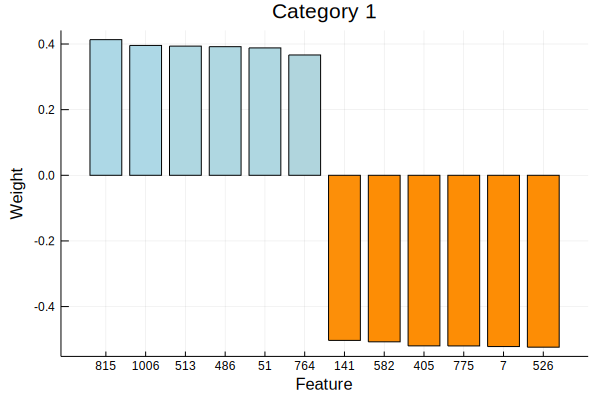

In [14]:
plot_features(lin, class=1) # plot the most important features for the model
# sadly, I couldn't find the words represented by the features for this dataset. The analysis would have been
# much more insightful with the actual words.